# Trabajo en Case 1

## Teoría
#### 1. Indique cual es costo de "Training" y de test del algoritmo KNN.
R/ El costo de entrenar es O(1), ya que es solo la carga de datos. El costo de entrenamiento es de O(N*D), donde N es la cantidad de datos, mientras que D son los features. En el peor caso donde N = D, este tendría un costo de O(N^2)

#### 2. Explique por qué se dice que instance learning es un algoritmo por fuerza bruta o perezoso.
R/ Este modelo solo se basa en comparación del dato a etiquetar con los N datos cargados en memoria, no existe un modelo que haga una simplificación, sólo comparaciones para aproximar el dato.

#### 3. Indique cuántas comparaciones se deben realizar en la etapa de test (asumiendo el peor de los casos).
R/ N*D pruebas, donde N es la cantidad de datos, mientras que D son los features. En el peor caso donde N = D, este tendria que hacer N^2 comparaciones

#### 4. Investigue alguna modificación que se ha realizado al algoritmo original del KNN.
R/ Una variante del algoritmo es el árbol KD, el cual consiste en mejorar la eficiencia de encontrar los k-vecinos más cercanos al indexar los ejemplos de entrenamiento en una estructura de árbol binario, donde en cada nivel del árbol el algoritmo selecciona una característica y divide los ejemplos de entrenamiento en dos subárboles según el valor medio de esa característica.


In [33]:
import numpy as np


In [52]:
class KNearestNeighbors():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 3

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def manhattan_distance(self, a, b):
        return np.abs(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []
        point_dist = []
        
        distance_function = self.euclidian_distance if self.weights == 'uniform' else self.manhattan_distance
        
        for x_test in X_test:
            point_dist += [ distance_function(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def predict(self, X_test):
        
        neighbors = self.kneighbors(X_test)
        y_pred = np.array([
            np.argmax(np.bincount(self.y_train[neighbor]))
            for neighbor in neighbors
        ])
        return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test)), y_pred, y_test


# Iris dataset (Observations/Treatments)

In [53]:
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from matplotlib import pyplot as plt
dataset = datasets.load_iris(as_frame=True)

X = dataset.data
y = dataset.target


In [54]:
mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X - mu ) / sigma

In [62]:
if isinstance(X, pd.DataFrame):
    X = X.to_numpy()
    y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(\
                X, y, test_size=0.3, random_state=12)



our_classifier = KNearestNeighbors(X_train, y_train, n_neighbors=50, weights='distance')
sklearn_classifier = KNeighborsClassifier(n_neighbors=50).fit(X_train, y_train)

our_accuracy, y_pred, y_test = our_classifier.score(X_test, y_test)
sklearn_accuracy = sklearn_classifier.score(X_test, y_test)

print(y_pred[:20], y_test[:20])

pd.DataFrame([[our_accuracy, sklearn_accuracy]],
             ['Accuracy'],    
             ['Our Implementation', 'Sklearn\'s Implementation'])

[0 1 0 1 2 2 2 0 2 0 1 0 0 0 2 2 2 1 0 1] [0 2 0 1 2 2 2 0 2 0 1 0 0 0 1 2 2 1 0 1]


,Our Implementation,Sklearn's Implementation
Accuracy,0.888889,0.888889


## 2) Clasificador de Múltiples Clases

In [48]:
import numpy as np

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits = load_digits(n_class=10, as_frame=True)

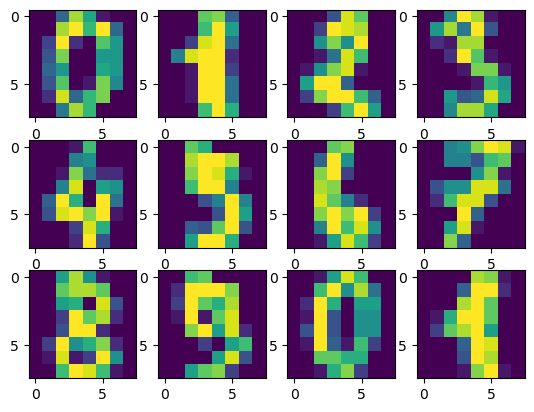

In [49]:
for i in range(1,13):
    plt.subplot(3, 4, i)
    plt.imshow(digits.images[i-1])

In [55]:
dimentions = digits.data.shape

import pandas as pd
pd.DataFrame([dimentions],
             ['Numbers'],    
             ['Data', 'Features'])

,Data,Features
Numbers,1797,64


In [185]:
X = digits.data
y = digits.target

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [187]:
class KNearestNeighborsDigits():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 3

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []
        point_dist = []
        
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)
    
    def kneighbors_mod(self, X_test, return_distance=False):
        # Custom distance implementation
        
        dist = []
        neigh_ind = []
        point_dist = []
        
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]
        
        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]
            
            # Different from regular distance, in our implementation 
            # we take the max and min distance values
            closest_neigh = sorted_neigh[0][1]
            farthest_neigh = sorted_neigh[-1][1]
            
            # Calculate the average distance         
            avg = sum(neigh[1] for neigh in sorted_neigh)/len(sorted_neigh)
                                    
            # And eliminate all the neighbors that are further than the average
            filtered_neigh = [neigh for neigh in sorted_neigh if neigh[1] <= avg]
            
            # With this, errors caused by smaller classes being out voted by
            # classes with more population are reduced
            
            ind_list = [tup[0] for tup in filtered_neigh]
            dist_list = [tup[1] for tup in filtered_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)
        
        if len(dist) >= 4:
            return np.array(neigh_ind, dtype=object)
        
        return np.array(neigh_ind)

    def predict(self, X_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            return y_pred

        if self.weights == 'distance':
            neighbors = self.kneighbors_mod(X_test)
            
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test)), y_pred, y_test


In [188]:
# Standardizing training data
mu = np.mean(training_data, 0)
sigma = np.std(training_data, 0)
training_data = (training_data - mu ) / sigma

# Standardizing test data
mu = np.mean(test_data, 0)
sigma = np.std(test_data, 0)
test_data = (test_data - mu ) / sigma

In [189]:
k_values = [2,3,5,7,8,10,11]

if isinstance(X, pd.DataFrame):
    X = X.to_numpy()
    y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(\
                X, y, test_size=0.25, random_state=45)


accuracy_values = []

for i in k_values:

    normal_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i)
    our_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i, weights='distance')
    sklearn_classifier = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    normal_accuracy = our_classifier.score(X_test, y_test)[0]
    our_accuracy = our_classifier.score(X_test, y_test)[0]
    sklearn_accuracy = sklearn_classifier.score(X_test, y_test)

    accuracy_values.append([normal_accuracy, our_accuracy, sklearn_accuracy])
    
pd.DataFrame(accuracy_values,
             [("K="+ str(k)) for k in k_values],    
             ['Accuracy (Normal)','Accuracy (Ours)', 'Accuracy (Sklearn)'])

,Accuracy (Normal),Accuracy (Ours),Accuracy (Sklearn)
K=2,0.984444,0.984444,0.982222
K=3,0.984444,0.984444,0.982222
K=5,0.982222,0.982222,0.977778
K=7,0.982222,0.982222,0.968889
K=8,0.982222,0.982222,0.968889
K=10,0.975556,0.975556,0.964444
K=11,0.977778,0.977778,0.966667


In [190]:
accuracy_values = []

for i in range(2, 100, 4): 
    normal_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i)
    our_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i, weights='distance')
    sklearn_classifier = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    normal_accuracy = our_classifier.score(X_test, y_test)[0]
    our_accuracy = our_classifier.score(X_test, y_test)[0]
    sklearn_accuracy = sklearn_classifier.score(X_test, y_test)

    accuracy_values.append([normal_accuracy, our_accuracy, sklearn_accuracy])

normal_acc = [acc[0] for acc in accuracy_values]
our_acc = [acc[1] for acc in accuracy_values]
sk_acc = [acc[2] for acc in accuracy_values]

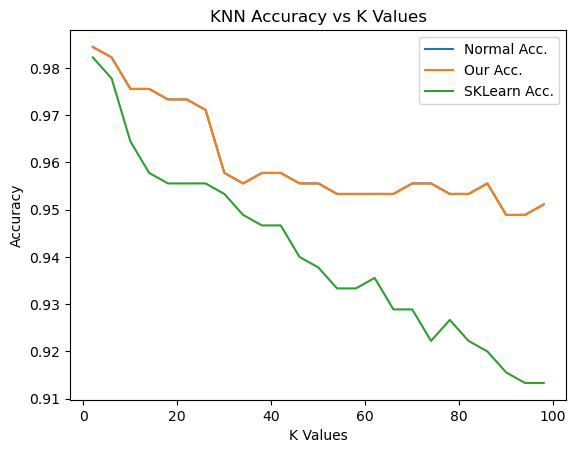

In [191]:
plt.plot(range(2, 100, 4), normal_acc, label="Normal Acc.")
plt.plot(range(2, 100, 4), our_acc, label="Our Acc.")
plt.plot(range(2, 100, 4), sk_acc, label="SKLearn Acc.")

plt.title('KNN Accuracy vs K Values')
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Resultados
Los resultados de la clasificacion de las imagenes indican que para los valores de K solicitados, la implementación de distancia propia tiene mejores resultados que los de la biblioteca sklearn. Sin embargo, al partir de la misma base que la implementación normal, los resultados de ambas implementaciones (propia y normal) arrojan los mismos resultados. 

Adicional a lo solicitado, se adjunta una gráfica para demostrar la caída en la precisión de las implementaciones conforme aumenta el valor de K, para valores entre 2 y 100, con saltos de 4 unidades. En esta se puede apreciar cómo el valor de la precisión se mantiene en el rando de 95%-96% para valores de K mayores a 30, mientras que la de sklearn, partiendo del mismo valor de 30, cae progresivamente hasta alcanzar val